# Pruning: A complete guide for beginners

## Goals

In this assignment, you will practice pruning a classical neural network model to reduce both model size and latency. The goals of this assignment are as follows:

- Understand the basic concept of **pruning**
- Implement and apply **fine-grained pruning**
- Implement and apply **channel pruning**
- Get a basic understanding of performance improvement (such as speedup) from pruning
- Understand the differences and tradeoffs between these pruning approaches

# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network.

Don't forget to go to runtime, and enable GPU

In [1]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys
    from urllib.request import urlretrieve
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [5]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [6]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [8]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc functions for verification.

In [9]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

Load the pretrained model and the CIFAR-10 dataset.

In [10]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [11]:
checkpoint_url = "https://hanlab.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

Downloading: "https://hanlab.mit.edu/files/course/labs/vgg.cifar.pretrained.pth" to ./vgg.cifar.pretrained.pth


=> loading checkpoint 'https://hanlab.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [12]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

100%|██████████| 170498071/170498071 [00:01<00:00, 86708481.13it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


# Let's First Evaluate the Accuracy and Model Size of Dense Model

Neural networks have become ubiquitous in many applications. Here we have loaded a pretrained VGG model for classifying images in CIFAR10 dataset.

Let's first evaluate the accuracy and model size of this model.

In [13]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


While large neural networks are very powerful, their size consumes considerable storage, memory bandwidth, and computational resources.
As we can see from the results above, a model for the task as simple as classifying $32\times32$ images into 10 classes can be as large as 35 MiB.
For embedded mobile applications, these resource demands become prohibitive.

Therefore, neural network pruning is exploited to facilitates storage and transmission of mobile applications incorporating DNNs.

The goal of pruning is to reduce the model size while maintaining the accuracy.

# Let's see the distribution of weight values

Before we jump into pruning, let's see the distribution of weight values in the dense model.

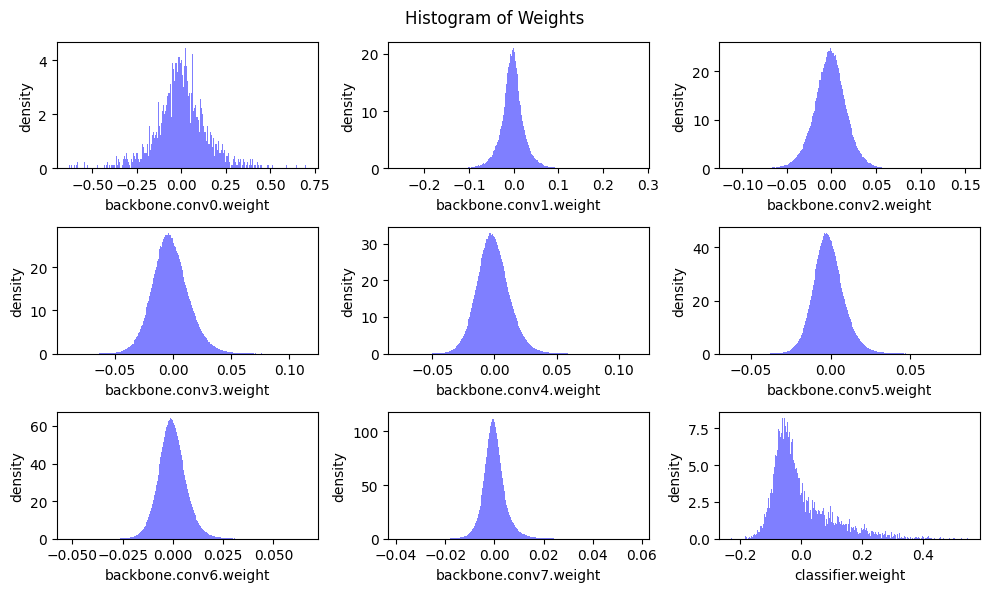

In [14]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

# Fine-grained Pruning

In this section, we will implement and perform fine-grained pruning.

Fine-grained pruning removes the synapses with lowest importance. The weight tensor $W$ will become sparse after fine-grained pruning, which can be described with **sparsity**:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

where $\#W$ is the number of elements in $W$.

In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.

## Magnitude-based Pruning

For fine-grained pruning, a widely-used importance is the magnitude of weight value, *i.e.*,

$Importance=|W|$

This is known as **Magnitude-based Pruning** (see [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)).

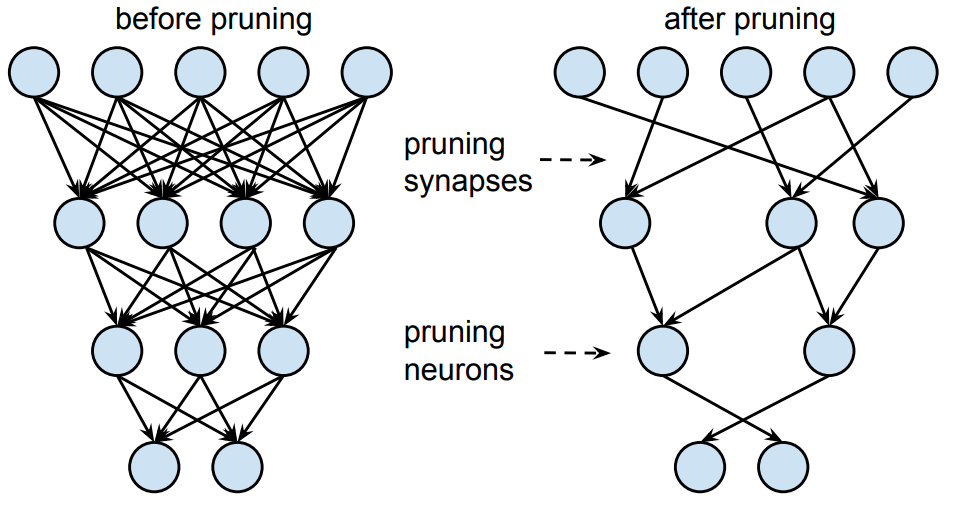

### Question 2

*   In step 1, we calculate the number of zeros (`num_zeros`) after pruning. Note that `num_zeros` should be an integer. You could use either `round()` or `int()` to convert a floating number into an integer. Here we use `round()`.
*   In step 2, we calculate the `importance` of weight tensor. Pytorch provides [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) APIs.
*   In step 3, we calculate the pruning `threshold` so that all synapses with importance smaller than `threshold` will be removed. Pytorch provides [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) APIs.
*   In step 4, we calculate the pruning `mask` based on the `threshold`. **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. `mask = importance > threshold`. Pytorch provides [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) API.

In [17]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(sparsity * num_elements)
    print('number of desired zeros', num_zeros)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    print("torch kth value")
    treshold, _ = torch.kthvalue(importance.flatten(), num_zeros)
    print("treshold", treshold.item())
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > treshold
    print("mask",mask)


    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask


Let's verify the functionality of defined fine-grained pruning by applying the function above on a dummy tensor.

number of desired zeros 19
torch kth value
treshold 0.38999998569488525
mask tensor([[ True,  True, False, False, False],
        [False,  True, False, False, False],
        [False, False, False, False, False],
        [False,  True, False, False, False],
        [ True, False, False, False,  True]])


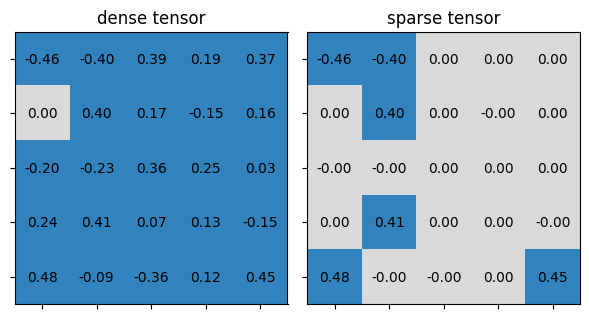

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [18]:
test_fine_grained_prune()

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class `FineGrainedPruner`, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

In [19]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity Scan


Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, we will only prune one layer to see the accuracy degradation. By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Here is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (*i.e.*, sparsity). The y-axis is the validation accuracy. (This is Figure 6 in [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf))


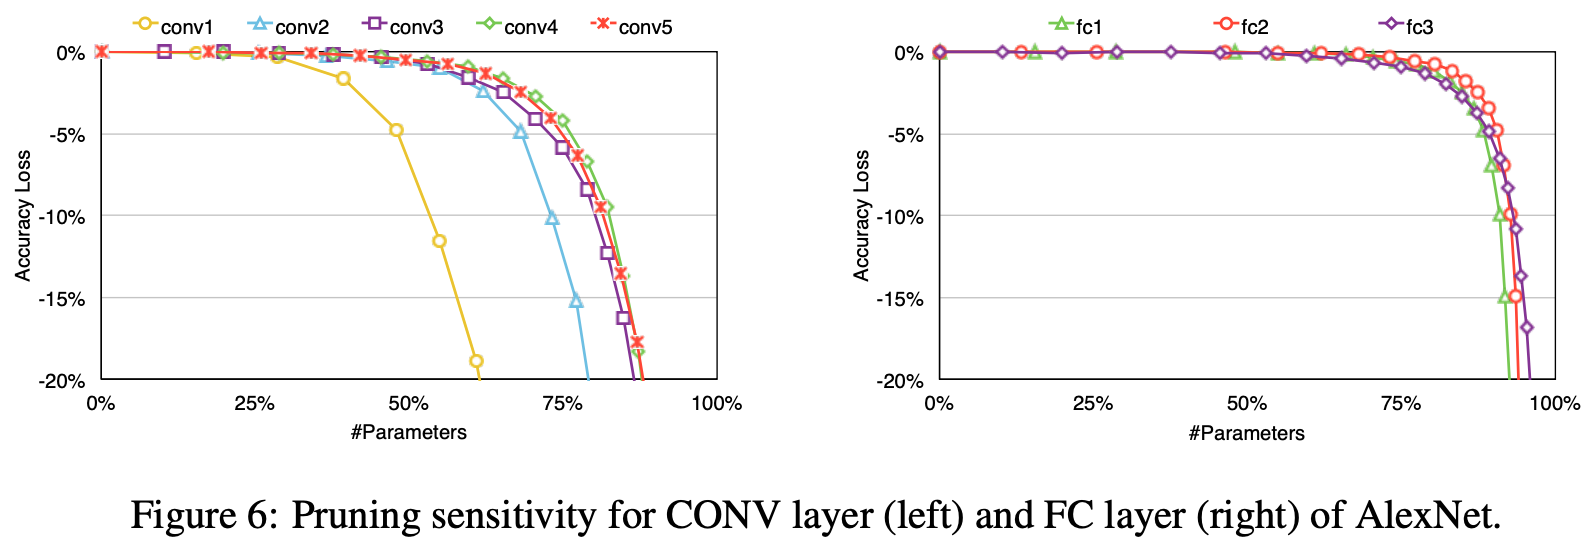

The following code cell defines the sensitivity scan function that returns the sparsities scanned, and a list of accuracies for each weight to be pruned.

In [20]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

Please run the following cells to plot the sensitivity curves. It should take around 2 minutes to finish.

In [21]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

number of desired zeros 691
torch kth value
treshold 0.05922764912247658
mask tensor([[[[ True,  True,  True],
          [False, False,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [ True, False,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [False, False, False],
          [ True,  True,  True]]],


        [[[False,  True,  True],
          [ True,  True,  True],
          [False, False,  True]],

         [[ True, False, False],
          [False,  True,  True],
          [ True, False,  True]],

         [[ True,  True,  True],
          [ True,  True,  True],
          [False, False,  True]]],


        [[[ True,  True,  True],
          [False,  True,  True],
          [ True,  True,  True]],

         [[False, False,  True],
          [ True,  True,  True],
          [False,  True,  True]],

         [[ True,  True,  True],
          [False,  True, False],
          [ True,  True,  True]]],


       

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

number of desired zeros 29491
torch kth value
treshold 0.010695112869143486
mask tensor([[[[ True,  True,  True],
          [ True,  True,  True],
          [False, False,  True]],

         [[ True,  True,  True],
          [ True,  True,  True],
          [False, False,  True]],

         [[ True,  True,  True],
          [False,  True,  True],
          [ True,  True,  True]],

         ...,

         [[False, False,  True],
          [False, False, False],
          [False,  True, False]],

         [[ True, False, False],
          [ True, False, False],
          [False, False,  True]],

         [[False, False, False],
          [False, False, False],
          [False, False, False]]],


        [[[False, False, False],
          [ True,  True,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [False, False,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [False, False, False],
          [ True,  True, Fal

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

number of desired zeros 117965
torch kth value
treshold 0.008722507394850254
mask tensor([[[[False, False, False],
          [ True, False,  True],
          [False,  True, False]],

         [[ True,  True, False],
          [ True,  True,  True],
          [ True,  True, False]],

         [[False, False,  True],
          [ True,  True,  True],
          [ True, False,  True]],

         ...,

         [[ True,  True,  True],
          [False,  True, False],
          [False, False, False]],

         [[ True,  True,  True],
          [ True,  True,  True],
          [ True, False, False]],

         [[False,  True,  True],
          [False,  True, False],
          [ True, False,  True]]],


        [[[False, False, False],
          [False,  True,  True],
          [ True, False,  True]],

         [[ True, False, False],
          [ True,  True,  True],
          [False,  True, False]],

         [[False, False,  True],
          [ True,  True,  True],
          [ True,  True, Fa

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

number of desired zeros 235930
torch kth value
treshold 0.007966496981680393
mask tensor([[[[False, False, False],
          [ True,  True, False],
          [False,  True,  True]],

         [[False, False,  True],
          [False,  True, False],
          [False, False,  True]],

         [[False,  True, False],
          [False,  True, False],
          [False, False, False]],

         ...,

         [[False, False,  True],
          [ True,  True,  True],
          [False, False, False]],

         [[ True,  True, False],
          [ True,  True, False],
          [ True, False,  True]],

         [[ True,  True, False],
          [ True,  True,  True],
          [False, False,  True]]],


        [[[False, False, False],
          [ True,  True, False],
          [ True, False,  True]],

         [[ True,  True, False],
          [False,  True,  True],
          [ True, False,  True]],

         [[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True, Fa

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

number of desired zeros 471859
torch kth value
treshold 0.006563288625329733
mask tensor([[[[ True,  True, False],
          [False,  True, False],
          [False, False,  True]],

         [[ True, False,  True],
          [False, False, False],
          [False,  True,  True]],

         [[False,  True,  True],
          [ True,  True,  True],
          [False, False, False]],

         ...,

         [[ True, False, False],
          [ True,  True, False],
          [ True,  True,  True]],

         [[ True, False,  True],
          [ True,  True, False],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [False, False,  True],
          [ True, False, False]]],


        [[[ True, False, False],
          [False, False, False],
          [False, False,  True]],

         [[False,  True,  True],
          [False, False,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [ True, False, False],
          [ True,  True,  T

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

number of desired zeros 943718
torch kth value
treshold 0.004849101882427931
mask tensor([[[[ True,  True,  True],
          [False,  True,  True],
          [ True,  True,  True]],

         [[ True,  True, False],
          [ True,  True,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [ True,  True, False],
          [ True, False, False]],

         ...,

         [[ True, False,  True],
          [ True,  True, False],
          [ True,  True,  True]],

         [[ True,  True, False],
          [ True, False,  True],
          [ True,  True,  True]],

         [[ True, False, False],
          [ True, False,  True],
          [False, False,  True]]],


        [[[ True,  True,  True],
          [False,  True,  True],
          [False, False,  True]],

         [[ True,  True, False],
          [False,  True, False],
          [False,  True, False]],

         [[ True, False, False],
          [ True, False,  True],
          [ True,  True,  T

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

number of desired zeros 943718
torch kth value
treshold 0.0033361606765538454
mask tensor([[[[False,  True,  True],
          [False, False, False],
          [False,  True, False]],

         [[False,  True,  True],
          [ True,  True, False],
          [False,  True,  True]],

         [[False,  True,  True],
          [ True,  True,  True],
          [ True,  True, False]],

         ...,

         [[ True,  True,  True],
          [ True,  True, False],
          [ True,  True, False]],

         [[ True, False, False],
          [ True,  True,  True],
          [ True,  True, False]],

         [[ True, False, False],
          [False, False,  True],
          [False,  True,  True]]],


        [[[False,  True,  True],
          [False,  True,  True],
          [False,  True,  True]],

         [[ True,  True,  True],
          [False,  True,  True],
          [ True,  True, False]],

         [[False,  True,  True],
          [False,  True,  True],
          [False, False,  

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

number of desired zeros 943718
torch kth value
treshold 0.0019331303192302585
mask tensor([[[[False,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],

         [[ True, False, False],
          [False,  True,  True],
          [ True, False, False]],

         [[ True, False,  True],
          [False,  True,  True],
          [ True,  True,  True]],

         ...,

         [[ True,  True,  True],
          [ True, False,  True],
          [False,  True,  True]],

         [[ True,  True,  True],
          [False,  True, False],
          [ True,  True,  True]],

         [[ True,  True, False],
          [False,  True,  True],
          [ True,  True,  True]]],


        [[[ True, False, False],
          [ True,  True, False],
          [ True, False,  True]],

         [[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [ True,  True,  True],
          [False,  True,  

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

number of desired zeros 2048
torch kth value
treshold 0.049543991684913635
mask tensor([[ True,  True, False,  ..., False,  True, False],
        [ True,  True, False,  ...,  True, False, False],
        [ True,  True, False,  ..., False, False, False],
        ...,
        [False,  True, False,  ..., False, False,  True],
        [False,  True, False,  ..., False,  True,  True],
        [False,  True, False,  ..., False,  True,  True]], device='cuda:0')
    sparsity=0.40: accuracy=92.91%number of desired zeros 2560
torch kth value
treshold 0.06006896123290062
mask tensor([[ True,  True, False,  ..., False,  True, False],
        [ True, False, False,  ...,  True, False, False],
        [ True,  True, False,  ..., False, False, False],
        ...,
        [False,  True, False,  ..., False, False,  True],
        [False,  True, False,  ..., False,  True,  True],
        [False, False, False,  ..., False,  True,  True]], device='cuda:0')
    sparsity=0.50: accuracy=92.83%number of desir

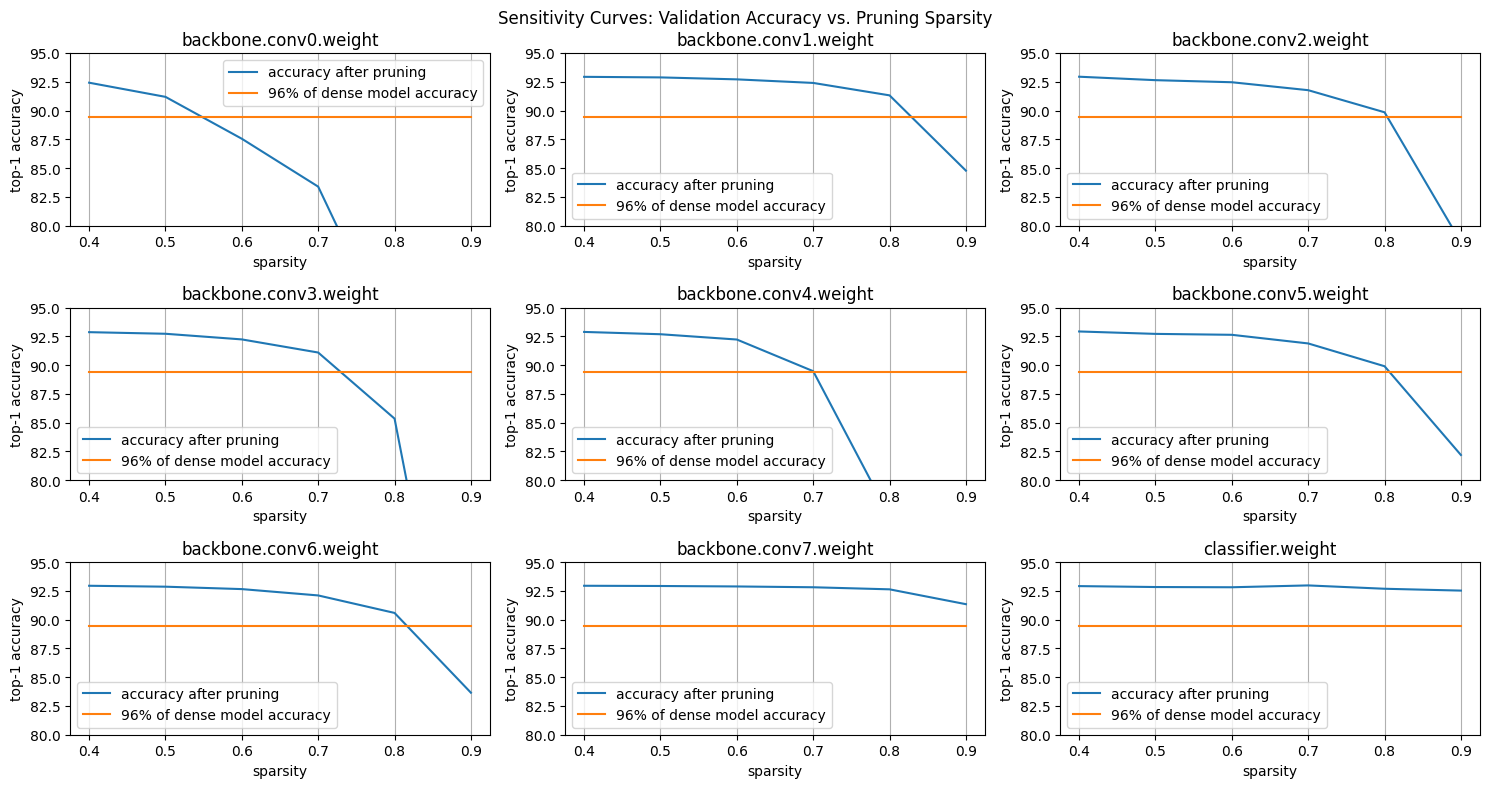

In [22]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

## \#Parameters of each layer
In addition to accuracy, the number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parameters require larger sparsities.

Please run the following code cell to plot the distribution of #parameters in the whole model.

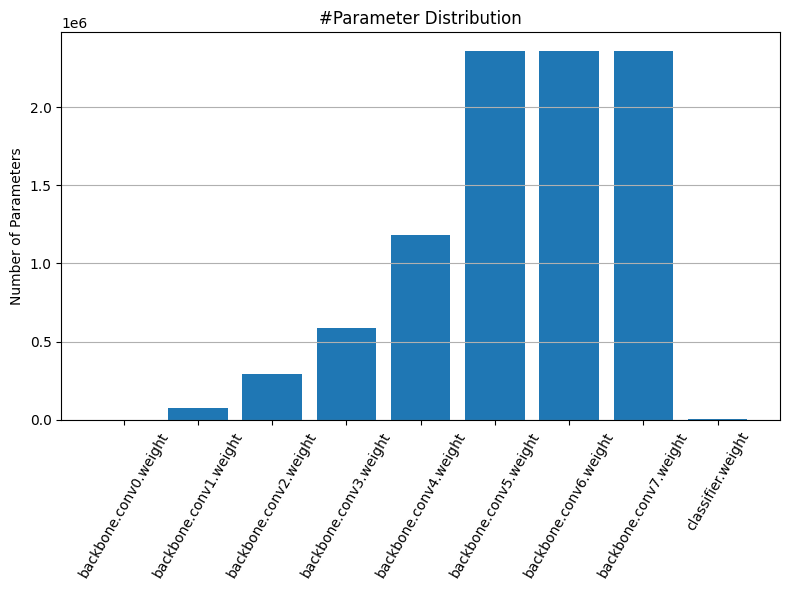

In [23]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

### Question 5

Based on the sensitivity curves and the distribution of #parameters in the model, please select the sparsity for each layer.

Note that the overall compression ratio of pruned model mostly depends on the layers with larger #parameters, and different layers have different sensitivity to pruning (see Question 4).

Please make sure that after pruning, the sparse model is 25% of the size of the dense model, and validation accuracy is higher than 92.5 after finetuning.

**Hint**:
*   The layer with more #parameters should have larger sparsity. (see *Figure #Parameter Distribution*)
*   The layer that is sensitive to the pruning sparsity (i.e., the accuracy will drop quickly as sparsity becomes higher) should have smaller sparsity. (see *Figure Sensitivity Curves*)

In [24]:
recover_model()

sparsity_dict = {
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'backbone.conv0.weight': 0.2,
    'backbone.conv1.weight': 0.25,
    'backbone.conv2.weight': 0.3,
    'backbone.conv3.weight': 0.5,
    'backbone.conv4.weight': 0.6,
    'backbone.conv5.weight': 0.75,
    'backbone.conv6.weight': 0.75,
    'backbone.conv7.weight': 0.85,
    'classifier.weight': 0

}

Please run the following cell to prune the model according to your defined `sparsity_dict`, and print the information of sparse model.

number of desired zeros 346
torch kth value
treshold 0.025971591472625732
mask tensor([[[[ True,  True,  True],
          [ True, False,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [False, False, False],
          [ True,  True,  True]]],


        [[[False,  True,  True],
          [ True,  True,  True],
          [False, False,  True]],

         [[ True, False, False],
          [False,  True,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [ True,  True,  True],
          [False,  True,  True]]],


        [[[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],

         [[ True, False,  True],
          [ True,  True,  True],
          [False,  True,  True]],

         [[ True,  True,  True],
          [False,  True, False],
          [ True,  True,  True]]],


      

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=91.03% before fintuning


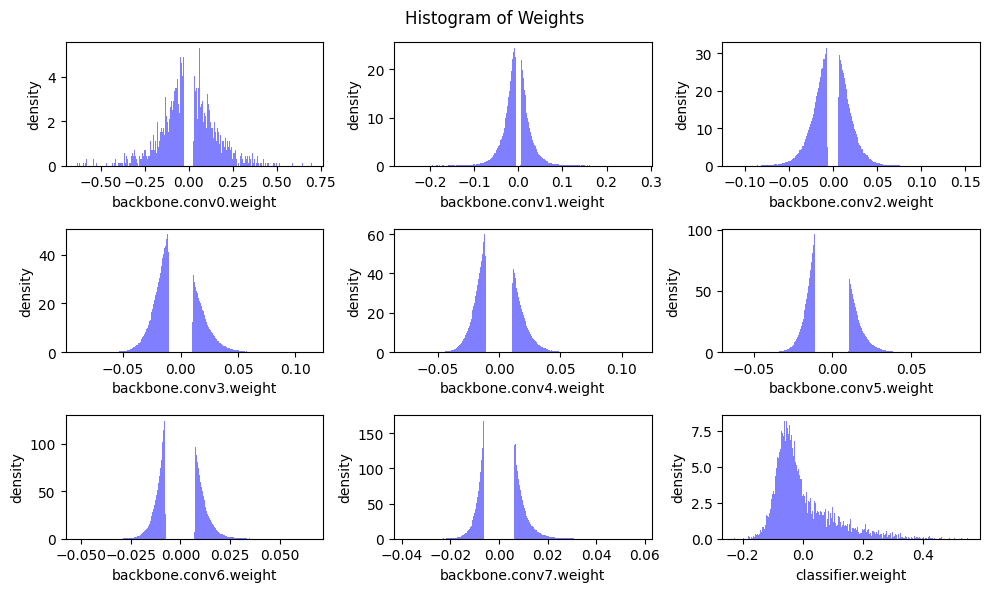

In [25]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

## Finetune the fine-grained pruned model

As we can see from the outputs of previous cell, even though fine-grained pruning reduces the most of model weights, the accuracy of model also dropped. Therefore, we have to finetune the sparse model to recover the accuracy.

Please run the following cell to finetune the sparse model. It should take around 3 minutes to finish.

In [28]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 92.85% / Best Accuracy: 92.85%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 93.00% / Best Accuracy: 93.00%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 92.93% / Best Accuracy: 93.00%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.83% / Best Accuracy: 93.00%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 92.89% / Best Accuracy: 93.00%


Run the following cell to see the information of best finetuned sparse model.

In [29]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=9.82 MiB = 27.89% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=93.00% after fintuning
